<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Decision Tree   
<font color=black size=4>
    Hamidreza Yaghoubi 
    
<br><br>
<font size=4>
In this homework, we are going to implement the Classification Decision Tree. Keep in mind to complete all of the following questions and write your own codes in the TODO cells.

## Arya Jalali 98105665

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 2: Classification Decision Tree (100 points)
We will implement a Classification Decision Tree from scratch in the following problem. Then we will use our model to predict malignant and benign breast cancer. For this purpose, we will use the breast_cancer.csv dataset which you can find more details about it <a href="https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset"><font face="Roboto">here</font></a>.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import log
import random

<font face="Times New Roman" size=4><div dir=ltr>
## Classification Decision Tree Class (60 points)
In this section, you only need to fill TODO parts. You can find the logic and formula in both course slides and the web, but fill it out on your own. 

In [19]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        if self.value is not None:
            return True
        return False

In [20]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    # me
    def is_splitting_finished(self, depth, num_class_labels, num_samples):
        return depth >= self.max_depth or num_samples < self.min_samples_split

    def split(self, X, y, feature, threshold):
        left_indexes = X[feature] <= threshold
        right_indexes = -left_indexes
        X_left = X[left_indexes]
        y_left = y[left_indexes]
        X_right = X[right_indexes]
        y_right = y[right_indexes]

        return X_left, X_right, y_left, y_right

    # me
    def entropy(self, y):
        pos = len(y[y['diagnosis'] == 1])
        neg = len(y[y['diagnosis'] == 0])
        total = pos + neg 

        if neg == 0 or pos == 0:
          return 0
        ent = pos/total * np.log2(pos/total) + neg/total * np.log2(neg/total)

        return -ent

    # me
    def information_gain(self, X, y, feature, threshold):
        if len(X) == 0:
          return 0

        X_left, X_right, y_left, y_right = self.split(X,y,feature,threshold)
        H_left = self.entropy(y_left)
        H_right = self.entropy(y_right)
        H_parent = self.entropy(y) 
        return H_parent - (H_left * len(y_left) / len(y) 
        + H_right * len(y_right) / len(y))


    # me
    def best_split(self, X, y):

        max_ig = -1
        best_feature, best_threshold = (None, None)

        for feature in X.columns:
          for threshold in sorted(X[feature].unique()):
            temp_ig = self.information_gain(X,y,feature,threshold)
            if temp_ig > max_ig:
              max_ig = temp_ig
              best_feature = feature
              best_threshold = threshold


        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if self.is_splitting_finished(depth, len(X.columns), len(X)):
            return None

        best_feature, best_threshold = self.best_split(X, y)
        X_left, X_right, y_left, y_right = self.split(X, y, best_feature, best_threshold)

        left_node = self.build_tree(X_left, y_left, depth=depth + 1)
        right_node = self.build_tree(X_right, y_right, depth=depth + 1)

        value = None
        if left_node is None or right_node is None:
            true_value = len(y[y['diagnosis'] == 1])
            false_value = len(y[y['diagnosis'] == 0])
            if true_value >= false_value:
                value = 1
            else:
                value = 0

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node, value=value)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict(self, X):
        tree = self.root
        predicted_value = []
        for index in list(X.index):
            data = X.loc[index]
            current_tree = tree
            for depth in range(self.max_depth):
                if Node.is_leaf(current_tree):
                    predicted_value.append(current_tree.value)
                    break
                feature = current_tree.feature
                threshold = current_tree.threshold
                if data[feature] <= threshold:
                    current_tree = current_tree.left
                if data[feature] > threshold:
                    current_tree = current_tree.right
        return predicted_value

<font face="Times New Roman" size=4><div dir=ltr>
## Data Prepration (20 points)
In this section, you must perform a good EDA for data. Then split it into train and validation data. We will then use the validation data to find the best model hyperparameters.  

In [21]:
data = pd.read_csv("sample_data/breast_cancer.csv")
data.head

<bound method NDFrame.head of      mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     diagnosis  
0            0  

In [22]:
data.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


<Figure size 842.4x595.44 with 0 Axes>

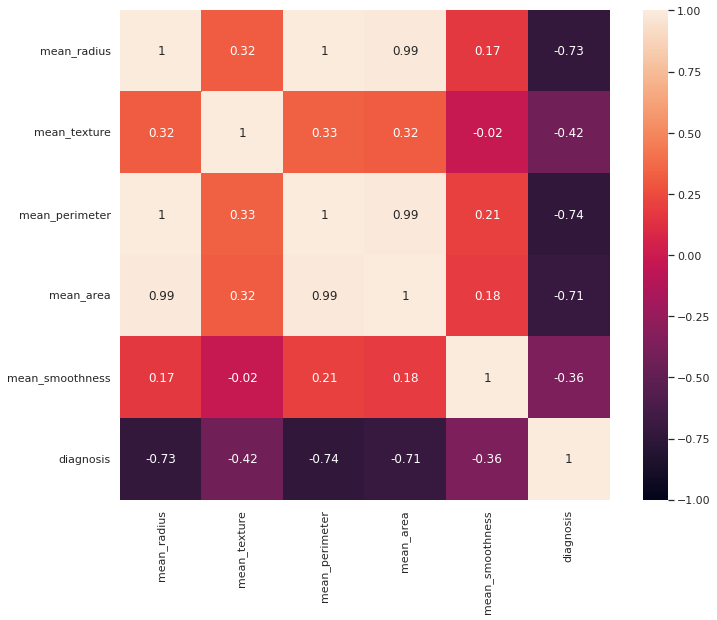

In [23]:
import matplotlib.pyplot as plt

def heatmap_corr(df):
	import seaborn as sns
	plt.figure() 
	corrmat = df.corr().round(2)
	f, ax = plt.subplots(figsize=(12, 9))
	sns.heatmap(corrmat, vmax=1.0, vmin=-1.0, square=True,annot = True)

heatmap_corr(data) 


### From the heatmap, we can infer that we have a lot of dependent features; for example there is a very high correlation between mean_area and mean_perimeter and mean radius. This isn't really that far-fetched if we assume breasts almost form a circle, and we know from elementary geometry that

$$
Area = \pi R^2, \hspace{0.5cm} Perimeter = 2\pi R
$$
### These 3 features put aside, there doesn't seem to be a lot of correlation between our features. All of this together means we could get rid of 2 of our aforementioned features, since they can approximately be obtained from the retained feature.

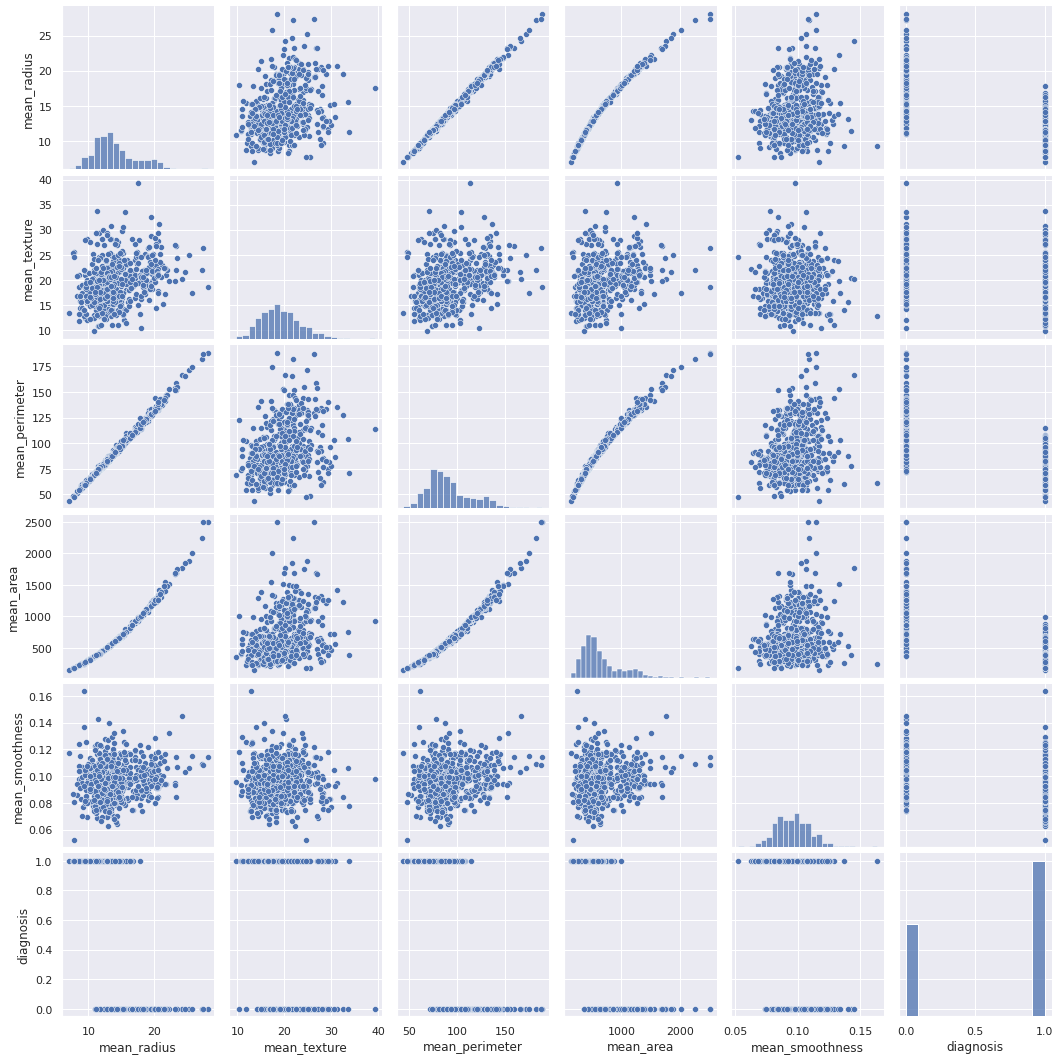

In [24]:
import seaborn as sns #seaborn

sns.pairplot(data)

### As we suspected, a relation can't be found between different features. We can also clearly see there is quadratic relationship between mean_area and mean_radius.Similarly there is a linear relationship between mean_perimeter and mean_radius. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


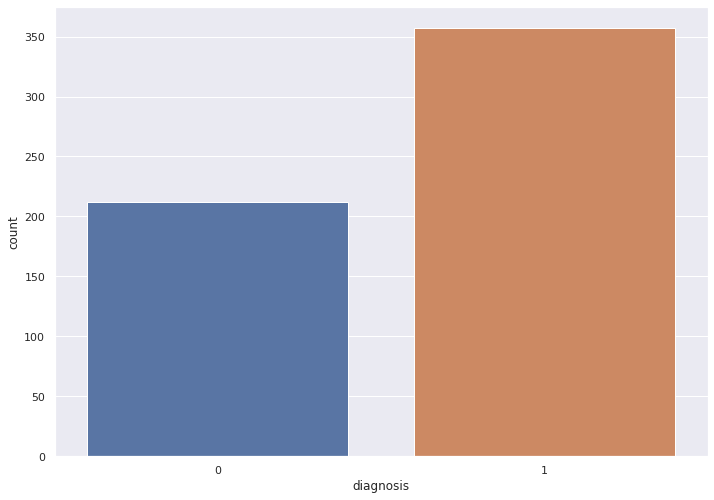

In [25]:
sns.countplot(data['diagnosis'])
plt.show()

### The ratio of confirmed cases to healthy cases seems to 3 to 2, which indicates a class imbalance. We can take advantage of class weights in different classification models to combat this imbalance.

In [26]:
X = data.drop('diagnosis', axis=1)
y = data[['diagnosis']]
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.70, random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
## Training And Tuning Hyperparameters (20 points)
In this section, you only need to find the best hyperparameters for your model. You can test different values and permutations of hyperparameters by adding them to the lists below. Your model must have at least accuracy=0.85 on validation data.

In [27]:
max_depths = [3,4,5]
min_samples_splits = [i for i in range(1,5)]

In [28]:
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0
best_model = None
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        clf = DecisionTree(max_depth, min_samples_split)
        clf.fit(x_train, y_train)
        y_val_pred = clf.predict(x_val)
        y_train_pred = clf.predict(x_train)
        accuracy = accuracy_score(y_val_pred, y_val)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        print(f"accuracy of training set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={train_accuracy}")
        print(f"accuracy of validation set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={accuracy}")
        print("------------------------------------------------")
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_model = clf

accuracy of training set for [min_samples_splits=1-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=1-max_depths=3] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=2-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=2-max_depths=3] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=3-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=3-max_depths=3] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=4-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=4-max_depths=3] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=1-max_depths=4] =0.9235294117647059
accuracy of validation set for 